In [335]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import trulia.stats
import geocoder
import json
from datetime import timedelta
from collections import defaultdict
import time
from statsmodels.graphics import tsaplots

In [139]:
tkey = 'vadwfc6dfjfxucmc5f3pqbd4'
zc = '90008'
sd = '2010-01-01'
ed = '2016-04-16'
data = trulia.stats.TruliaStats(tkey).get_zip_code_stats(zip_code=zc, start_date=sd, end_date=ed)

In [141]:
data.keys()

[u'location', u'trafficStats', u'listingStats']

In [156]:
weeks = []
medians = []
for week in data['listingStats']['listingStat']:
    weeks.append(week['weekEndingDate'])
    medians.append(week['listingPrice']['subcategory'][0]['medianListingPrice'])

In [166]:
df = pd.DataFrame({'week': weeks, 'medianPrice': medians})
df['week'] = pd.to_datetime(df['week'])
df['medianPrice'] = df['medianPrice'].astype(float)
df.sort('week', inplace=True)
df.set_index('week', inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


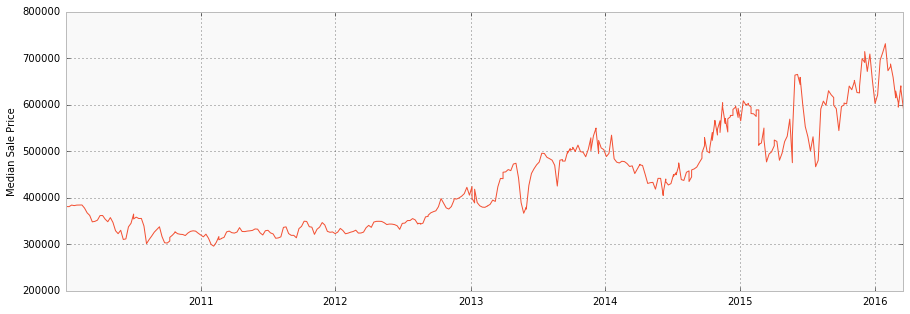

In [311]:
plt.figure(figsize=(15,5))
plt.plot(df)
plt.ylabel('Median Sale Price')
plt.show()

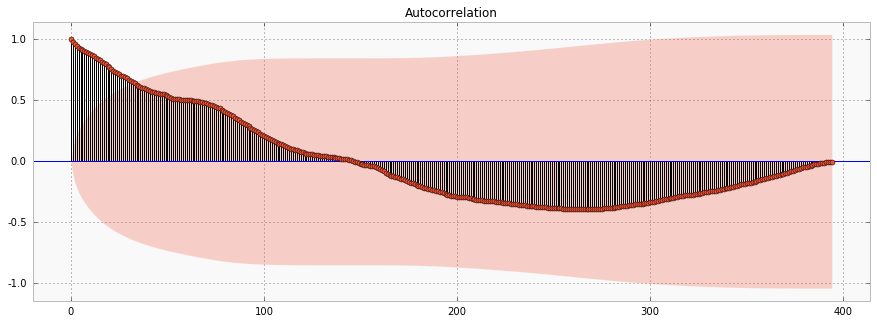

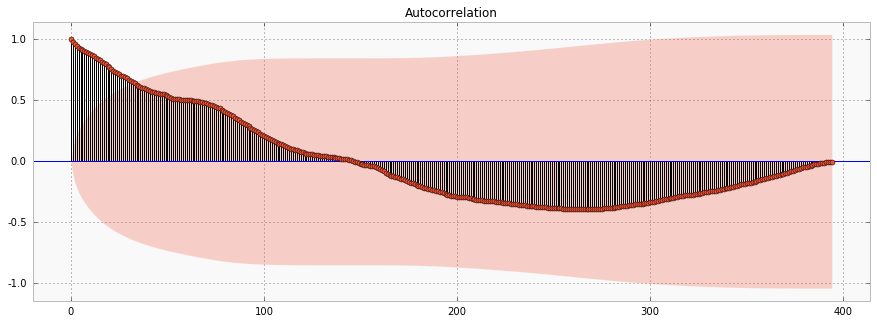

In [348]:
fig, axes = plt.subplots(nrows=1, figsize=(15,5))
tsaplots.plot_acf(df, axes)

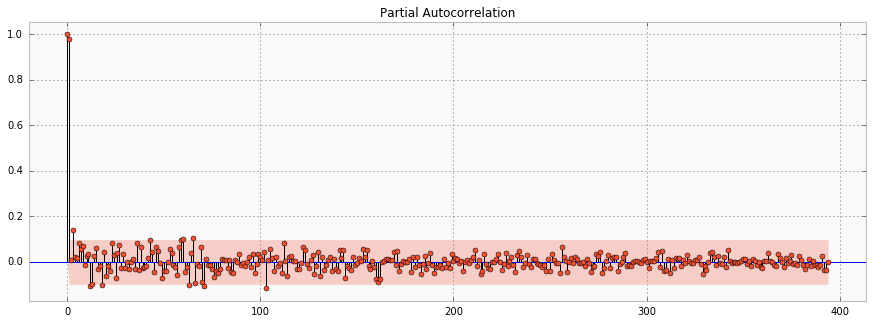

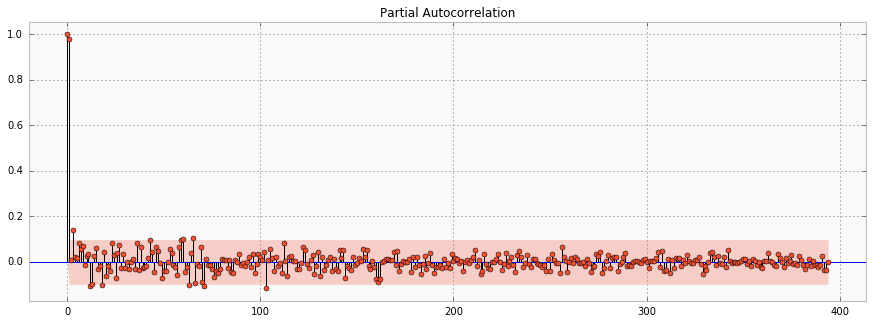

In [349]:
fig, axes = plt.subplots(nrows=1, figsize=(15,5))
tsaplots.plot_pacf(df, axes)

In [179]:
g = geocoder.google('Chapel Hill, NC')

In [309]:
sd2 = pd.to_datetime(sd).to_datetime()
ed2 = pd.to_datetime(ed).to_datetime()

In [237]:
api_key = 'd1348341d59bd2074fc5c5aec6950894'

In [289]:
cache = defaultdict(str)

In [310]:
x = sd2 + timedelta(hours=9)
while x < datetime.now():
    url = 'https://api.forecast.io/forecast/{}/{},{},{}'.format(api_key, g.lat, g.lng, x.strftime("%Y-%m-%dT%H:%M:%S"))
    if cache[url] == '':
        r2 = requests.get(url)
        time.sleep(.5)
        resp = json.loads(r2.content)
        cache[url] = resp
    x = x + timedelta(days=1)

In [312]:
times = []
temps = []
x = sd2 + timedelta(hours=9)
while x < datetime.now():
    url = 'https://api.forecast.io/forecast/{}/{},{},{}'.format(api_key, g.lat, g.lng, x.strftime("%Y-%m-%dT%H:%M:%S"))
    resp = cache[url]
    times.append(x)
    temps.append(resp['currently']['temperature'])
    x = x + timedelta(days=1)

In [313]:
df2 = pd.DataFrame({'time': times, 'temp': temps})
df2.set_index('time', inplace=True)

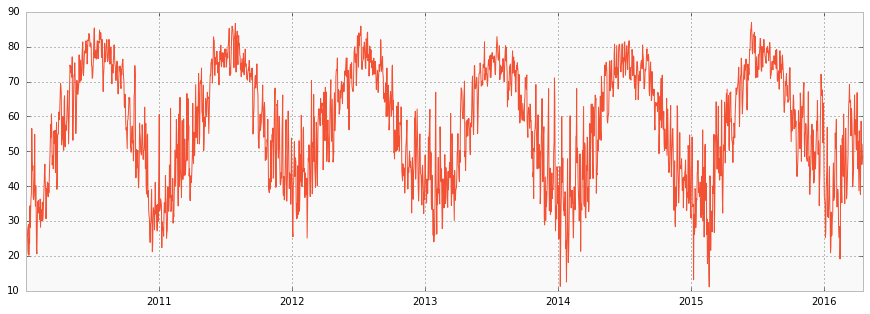

In [314]:
plt.figure(figsize=(15,5))
plt.plot(df2)
plt.show()

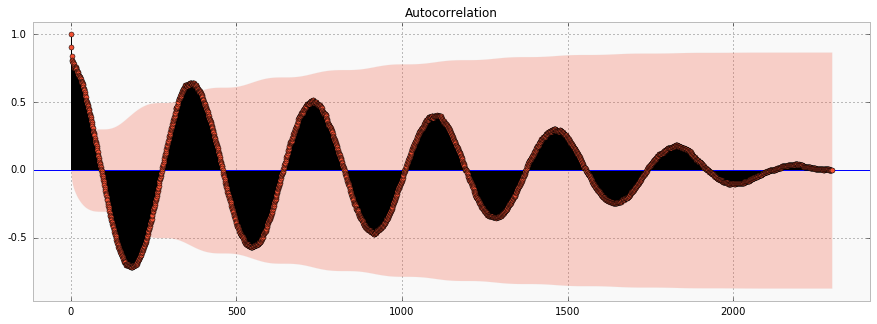

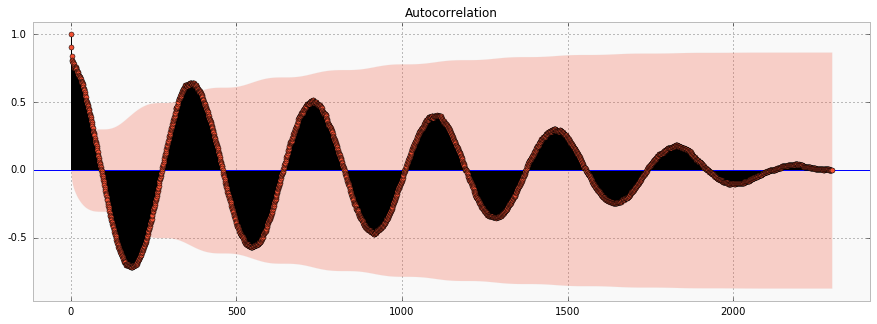

In [346]:
fig, axes = plt.subplots(nrows=1, figsize=(15,5))
tsaplots.plot_acf(df2, axes)

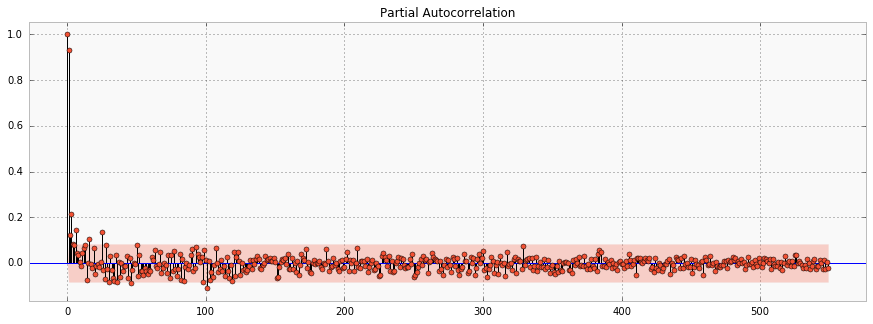

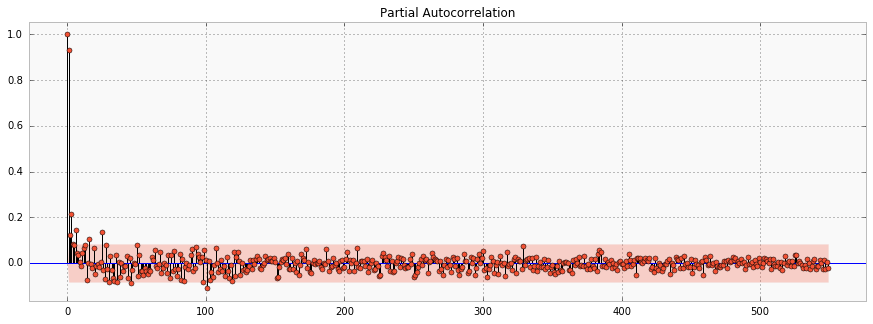

In [355]:
fig, axes = plt.subplots(nrows=1, figsize=(15,5))
tsaplots.plot_pacf(df2[0:550], axes)

In [321]:
import statsmodels.api as sm
tsa = sm.tsa # as shorthand
mdata = sm.datasets.macrodata.load().data
endog = np.log(mdata['m1'])
exog = np.column_stack([np.log(mdata['realgdp']), np.log(mdata['cpi'])])
exog = sm.add_constant(exog, prepend=True)
res1 = sm.OLS(endog, exog).fit()
print res1.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     9871.
Date:                Mon, 18 Apr 2016   Prob (F-statistic):          1.34e-200
Time:                        03:37:04   Log-Likelihood:                 221.75
No. Observations:                 203   AIC:                            -437.5
Df Residuals:                     200   BIC:                            -427.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.5016      0.353     -4.256      0.0

In [328]:
#acf, ci, Q, pvalue = 
tsa.acf(res1.resid, nlags=4, qstat=True, unbiased=True)


(array([ 1.        ,  0.98234045,  0.94759323,  0.90362911,  0.84956461]),
 array([ 198.80284036,  384.71069635,  554.61341702,  705.54830795]),
 array([  3.81138443e-045,   2.89157008e-084,   6.94932940e-120,
          2.19208642e-151]))

In [334]:
tsa

<module 'statsmodels.tsa.api' from '/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/api.pyc'>